# Metric Presentation and Visualization

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')

from discriminative_metrics import discriminative_score_metrics
from predictive_metrics import predictive_score_metrics
from metric_utils import generate_ks_results, visualization, display_scores

In [2]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

## Data Loading

In [3]:
# specify the --name argument
experiment_name = "hepc"

In [4]:
iterations = 5
real_data = np.load(f'../data/real_paths/{experiment_name}.npy')
generated_data = np.load(f'../data/generated_paths/{experiment_name}.npy')

In [5]:
# minmax scale the inputs for fair comparison
data_min = np.min(real_data, axis=(0,1), keepdims=True)
data_max = np.max(real_data, axis=(0,1), keepdims=True)

real_data = (real_data - data_min) / (data_max - data_min)
generated_data = (generated_data - data_min) / (data_max - data_min)

In [6]:
# test set
real_data = real_data[-1000:]

In [7]:
num_samples, seq_len, dim = real_data.shape
real_data.shape, generated_data.shape

((1000, 1000, 1), (1000, 1000, 1))

## Discriminative and Predictive Scores
**Note:** Due to slight implementation changes in how the metrics are calculated, the scores may not match exactly with those listed in the arXiv paper. An updated version with revised metrics will be released soon.

In [8]:
discriminative_score = []

for i in range(iterations):
    temp_disc, fake_acc, real_acc = discriminative_score_metrics(real_data, generated_data)
    discriminative_score.append(temp_disc)
    print(f'Iter {i}: ', temp_disc, '\n')
      
print(f'{experiment_name}:')
display_scores(discriminative_score)
print()

training:   0%|          | 0/2000 [00:00<?, ?it/s]

Iter 0:  0.11750000000000005 



training:   0%|          | 0/2000 [00:00<?, ?it/s]

Iter 1:  0.17000000000000004 



training:   0%|          | 0/2000 [00:00<?, ?it/s]

Iter 2:  0.025000000000000022 



training:   0%|          | 0/2000 [00:00<?, ?it/s]

Iter 3:  0.07750000000000001 



training:   0%|          | 0/2000 [00:00<?, ?it/s]

Iter 4:  0.08499999999999996 

hepc:
Final Score:  0.09500000000000001 ± 0.04782781617427249



In [9]:
predictive_score = []
for i in range(iterations):
    temp_pred = predictive_score_metrics(real_data, generated_data)
    predictive_score.append(temp_pred)
    print(i, ' epoch: ', temp_pred, '\n')
      
print(f'{experiment_name}:')
display_scores(predictive_score)
print()

training:   0%|          | 0/5000 [00:00<?, ?it/s]

0  epoch:  0.04440873104892671 



training:   0%|          | 0/5000 [00:00<?, ?it/s]

1  epoch:  0.043825964799150824 



training:   0%|          | 0/5000 [00:00<?, ?it/s]

2  epoch:  0.07354573842510581 



training:   0%|          | 0/5000 [00:00<?, ?it/s]

3  epoch:  0.04411978822946548 



training:   0%|          | 0/5000 [00:00<?, ?it/s]

4  epoch:  0.04355629034712911 

hepc:
Final Score:  0.04989130256995559 ± 0.01183065514693424



## KS Test Scores on Marginals

In [10]:
pct_marginals = (0.3, 0.5, 0.7, 0.9)
real_dataloader = DataLoader(TensorDataset(torch.tensor(real_data)), batch_size=64, shuffle=True)
generated_dataloader = DataLoader(TensorDataset(torch.tensor(generated_data)), batch_size=64, shuffle=True)
infinite_real_dataloader = (elem for it in iter(lambda: real_dataloader, None) for elem in it)
infinite_generated_dataloader = (elem for it in iter(lambda: generated_dataloader, None) for elem in it)
ks_results = generate_ks_results(infinite_real_dataloader, infinite_generated_dataloader, pct_marginals, 1000, dims=dim)
ks_stats = ks_results[:,:,:,0]
ks_pvals = ks_results[:,:,:,1]

In [11]:
mean_score = np.mean(ks_stats, axis=0)
std_score = np.std(ks_stats, axis=0)
percent_reject = np.mean(ks_pvals <= 0.05, axis=0)
# print as a table
mean_score_per_marginal = np.mean(mean_score, axis=0)
std_score_per_marginal = np.mean(std_score, axis=0)
mean_pct_reject_per_marginal = np.mean(percent_reject, axis=0)
print('KS Test:')
print('Marginal\tMean KS\t% Reject')
for i, pct in enumerate(pct_marginals):
    print(f'{pct}\t{mean_score_per_marginal[i]:.2f}\t{mean_pct_reject_per_marginal[i]*100:.2f}')

KS Test:
Marginal	Mean KS	% Reject
0.3	0.20	16.90
0.5	0.18	8.80
0.7	0.19	13.70
0.9	0.21	23.60


## t-SNE Plots

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.557163
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.019936
[t-SNE] KL divergence after 300 iterations: 2.233179


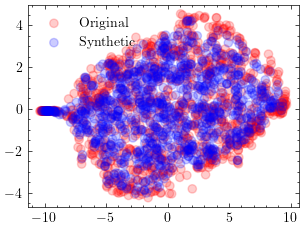

In [12]:
visualization(real_data, generated_data, "tsne")